In [4]:
# ----------------------------------------------------------------------------
#
# TITLE - orbit_plots.ipynb
# AUTHOR - James Lane
# PROJECT - OHStars
#
# ----------------------------------------------------------------------------
#
# Docstrings and metadata:
'''
Make plots of orbits for the OH project
'''

__author__ = "James Lane"

In [5]:
### Imports

## Basic
import numpy as np
import sys, os, pdb, warnings
from tqdm import tqdm_notebook as tqdm_nb

## Plotting
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib import cm
from matplotlib.collections import LineCollection

## Astropy
from astropy import table
from astropy import units as apu
from astropy.utils.exceptions import AstropyWarning

## galpy
from galpy import orbit
from galpy import potential
from galpy.util import bovy_coords as gpcoords
from galpy.util import bovy_conversion as gpconv
from galpy.util import bovy_plot as gpplot

# Project-specific
sys.path.append('../../src')
import ohstars.analysis

In [6]:
# Matplotlib for notebooks
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Meta
## Future Work

## Information
- Gaia co-variance information: https://www.aanda.org/articles/aa/pdf/2012/07/aa18807-12.pdf

# Preparation
## Keywords

In [7]:
# Perform the analysis on all stars? False for skip
include_stars = [True, True, True, True, True, True]

# Integration keywords
t_orbit = 5 # Gyr

# Declare the potential
pot = potential.MWPotential2014

## Read Data

In [8]:
# Filename
filename = '../../data/gaia/allstars.vot'

# Read the file
with warnings.catch_warnings():
    warnings.simplefilter('ignore', AstropyWarning)
    tab = table.Table.read(filename)
    
n_stars = len(tab) # 6
star_names = tab['col1'].data.astype(str)

## Prepare RV Data

In [9]:
# RV is uncorrelated with gaia so sample individually. From some Table I have (ref? In paper?)
vrad = np.array([-314.41, -136.80, -361.75, -372.09, -321.48, -214.37 ])
# vrad_err = np.array([0.26,0.14,0.67,0.32,0.28,0.26])

# Integrate
Loop over each star and plot its orbit

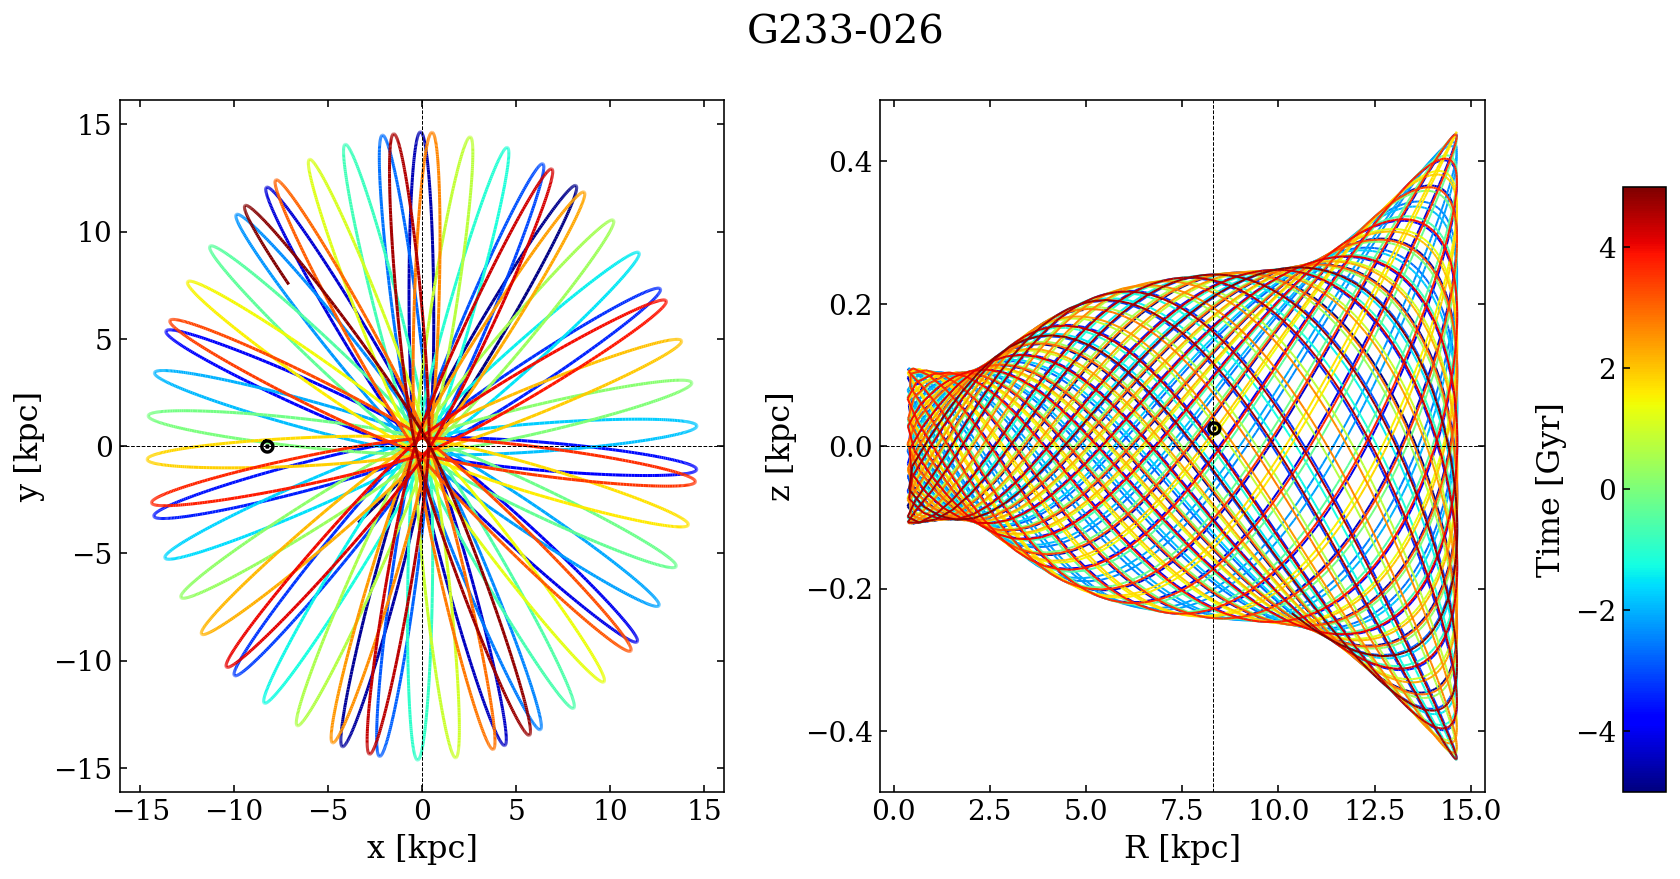

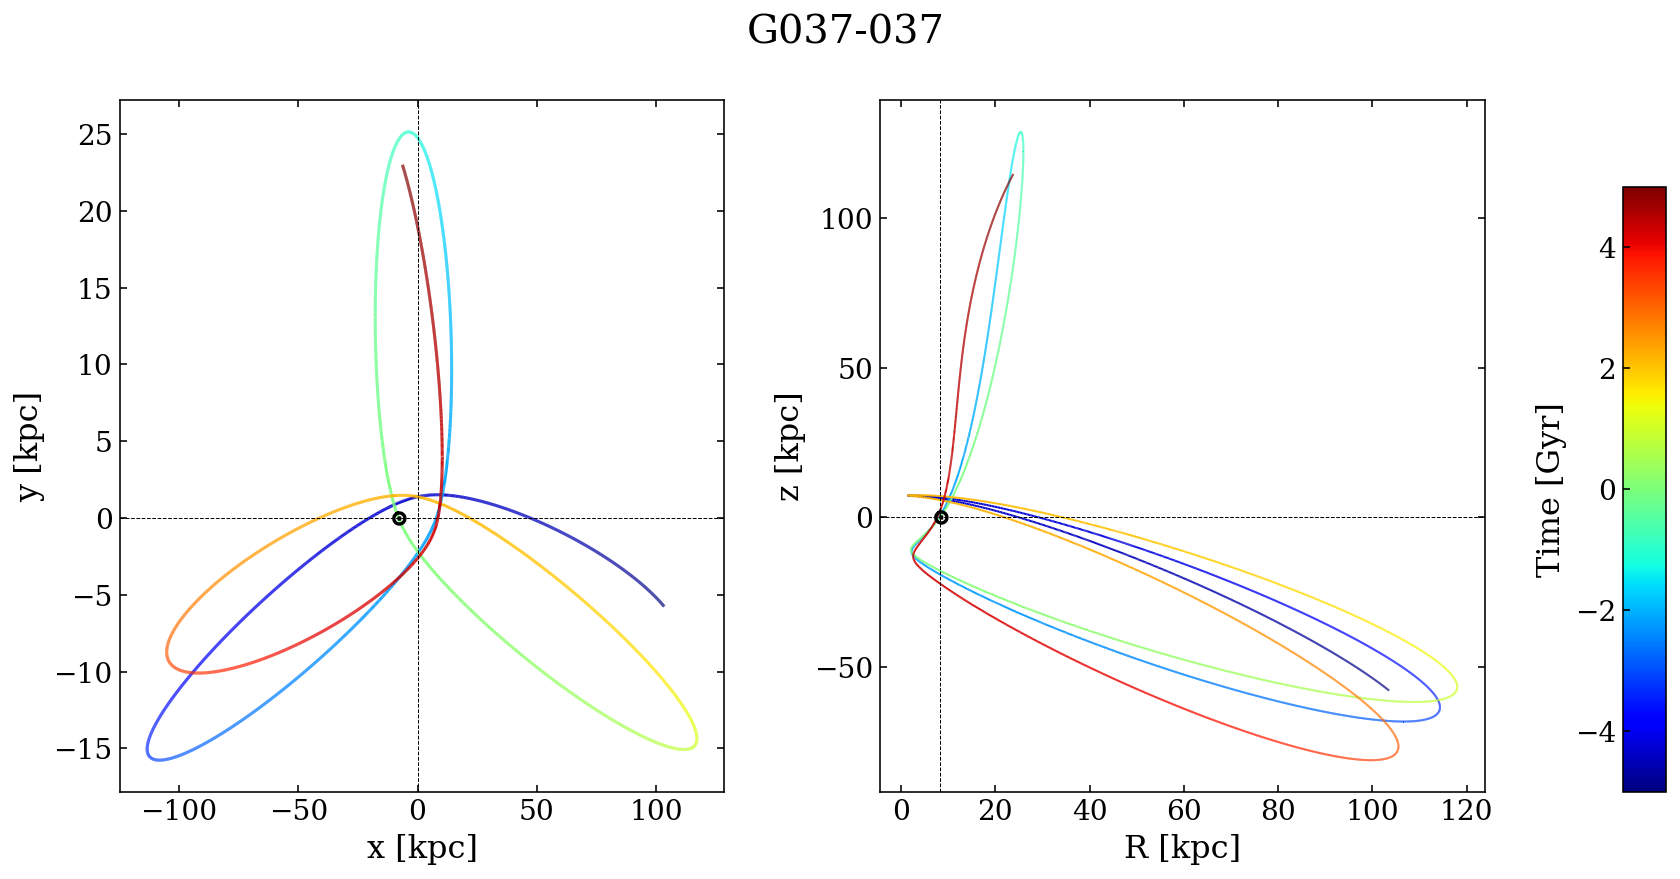

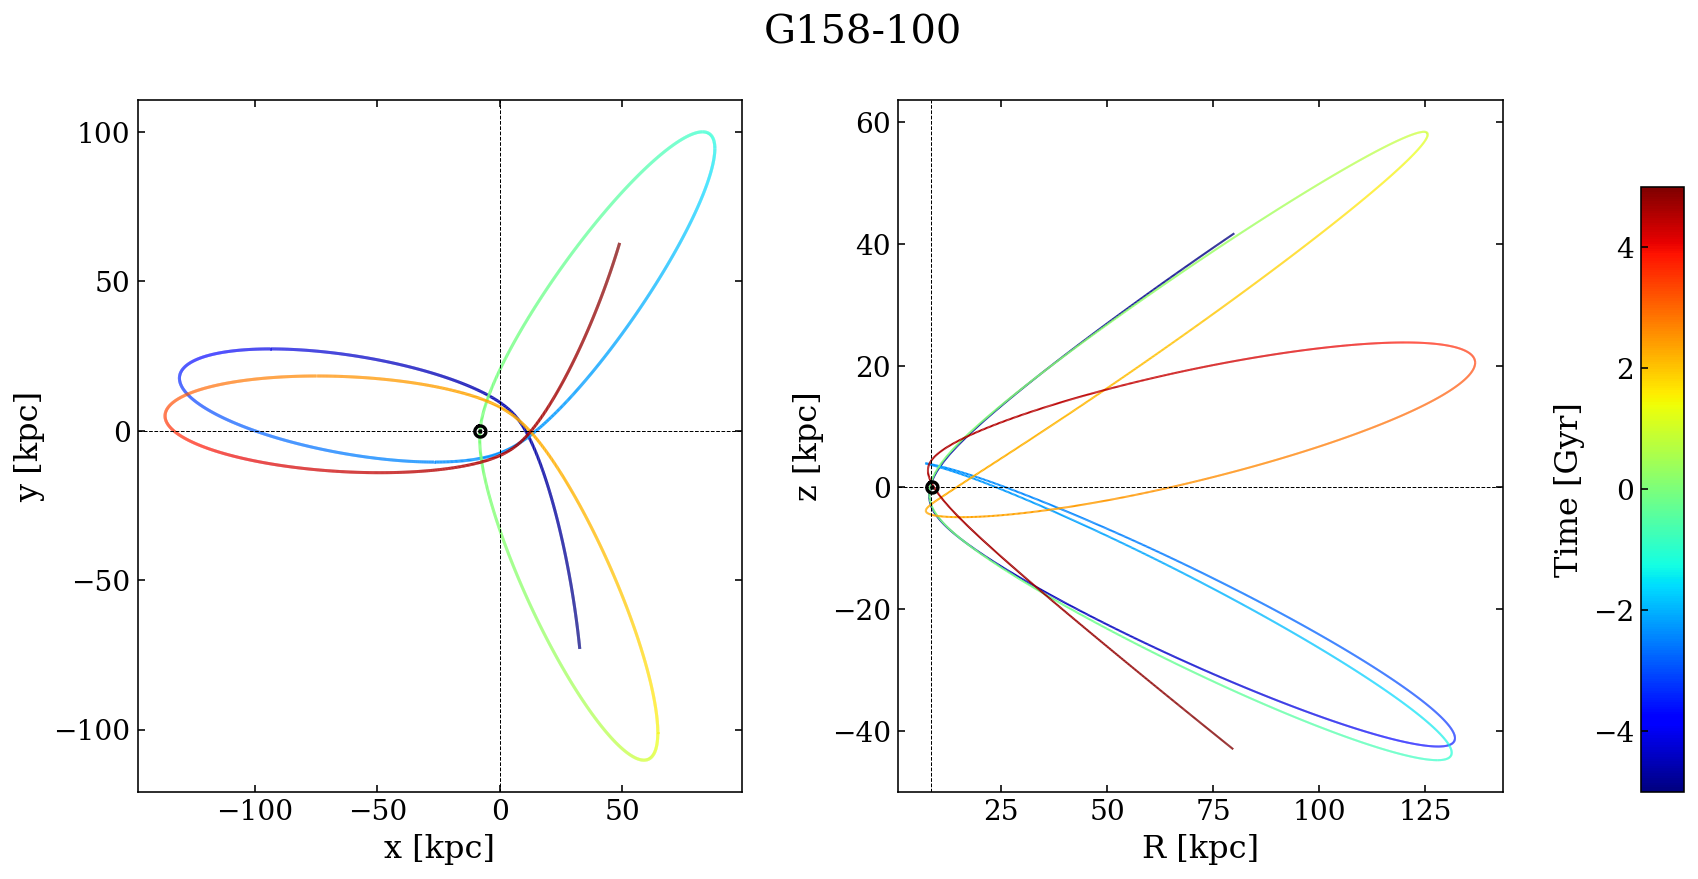

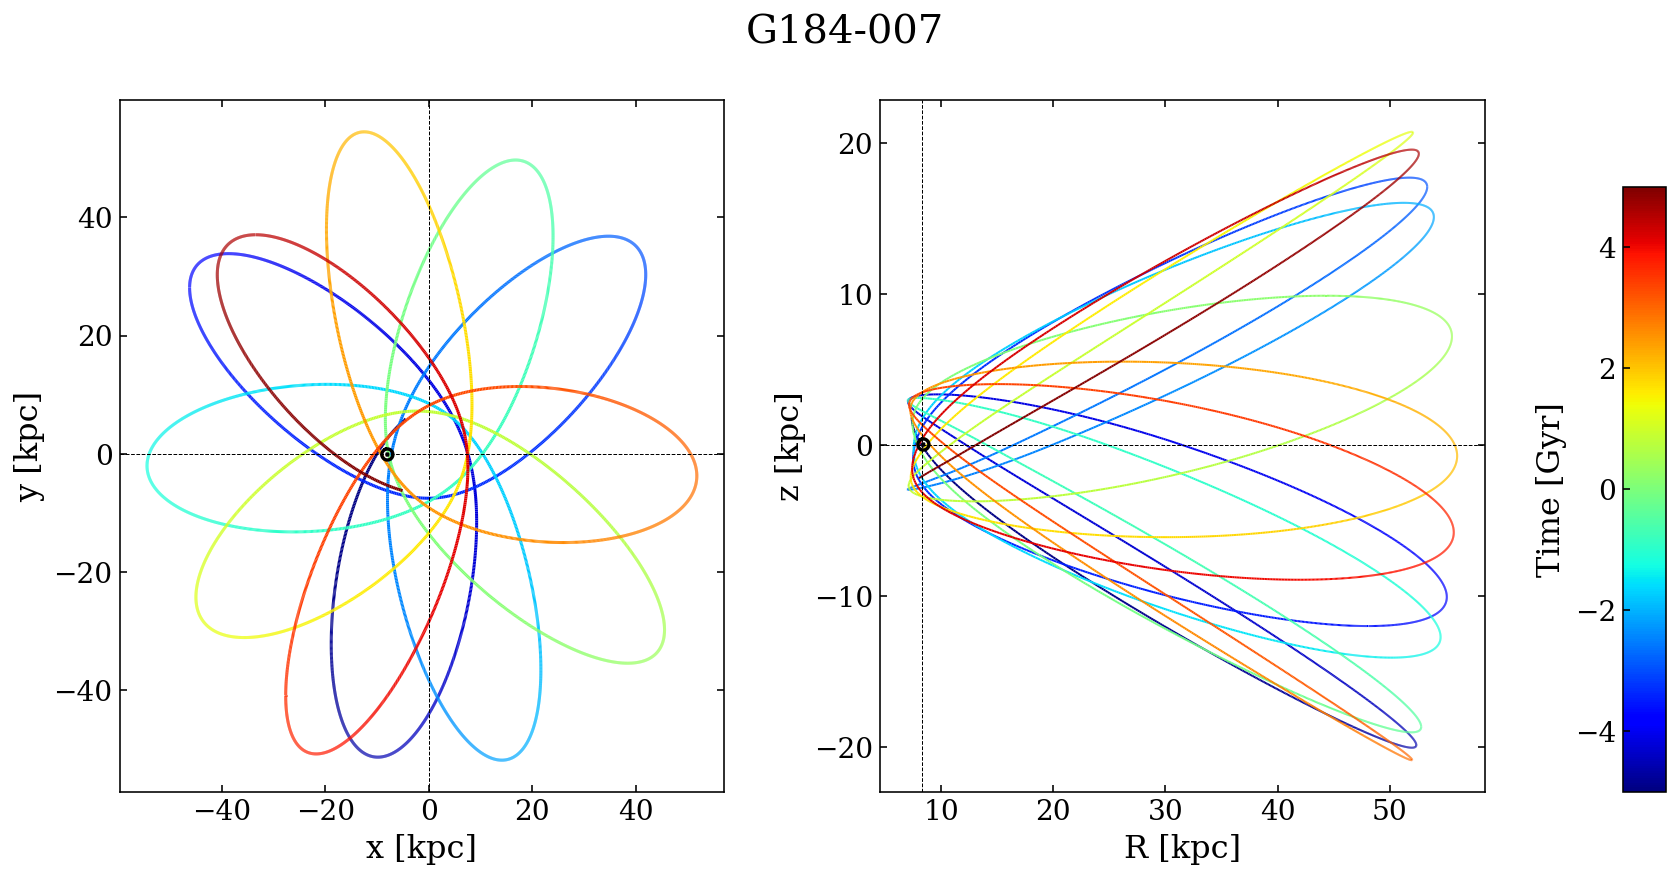

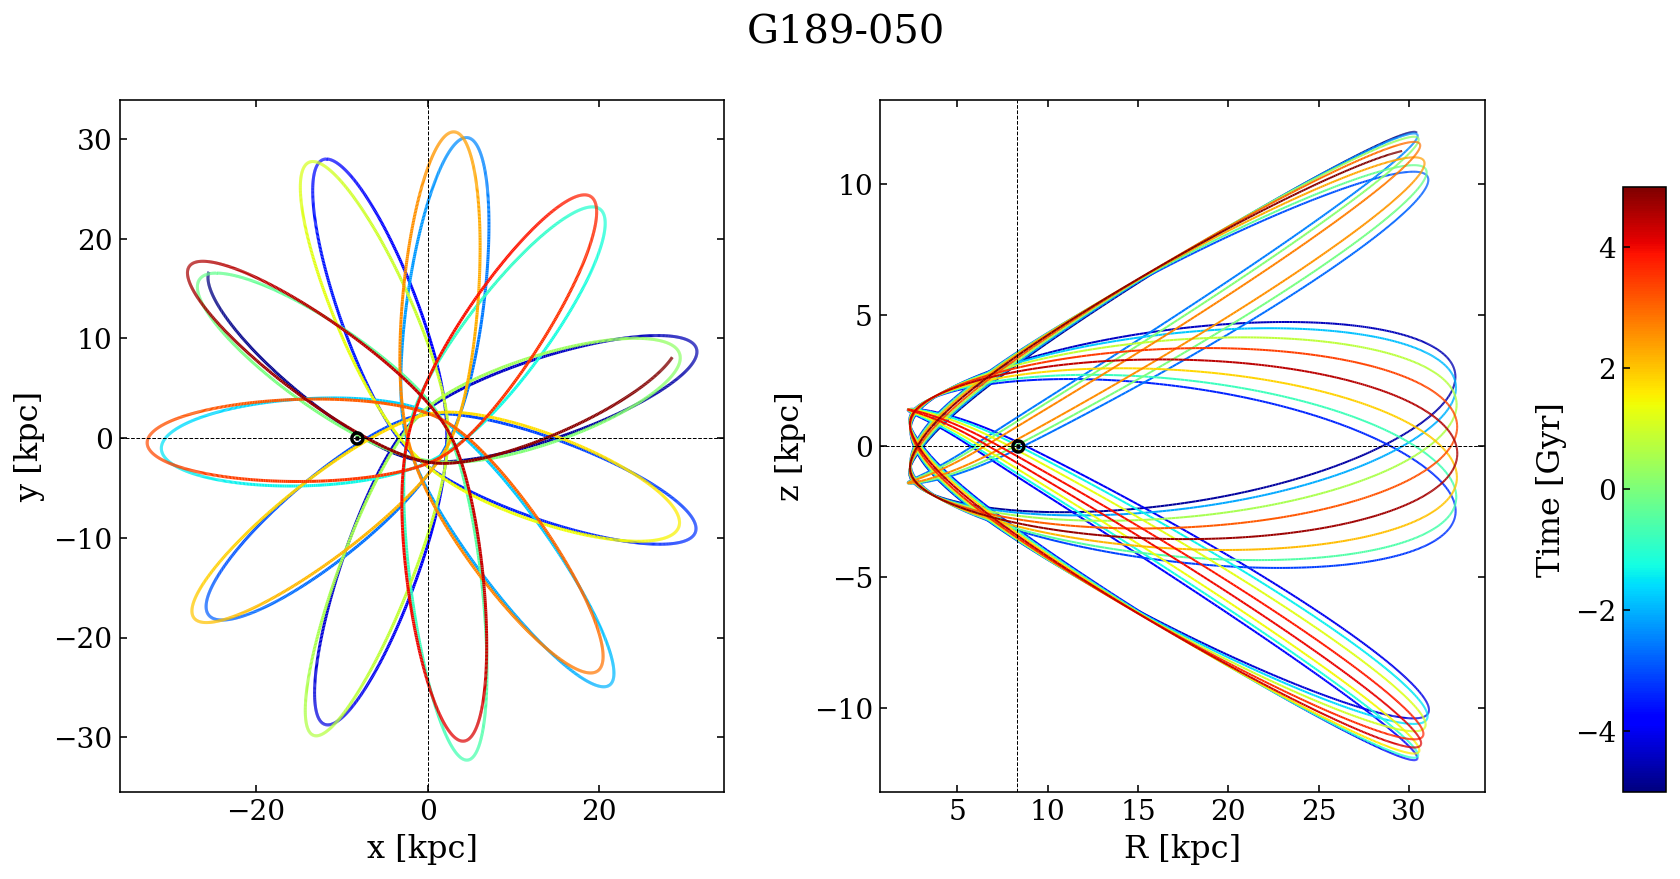

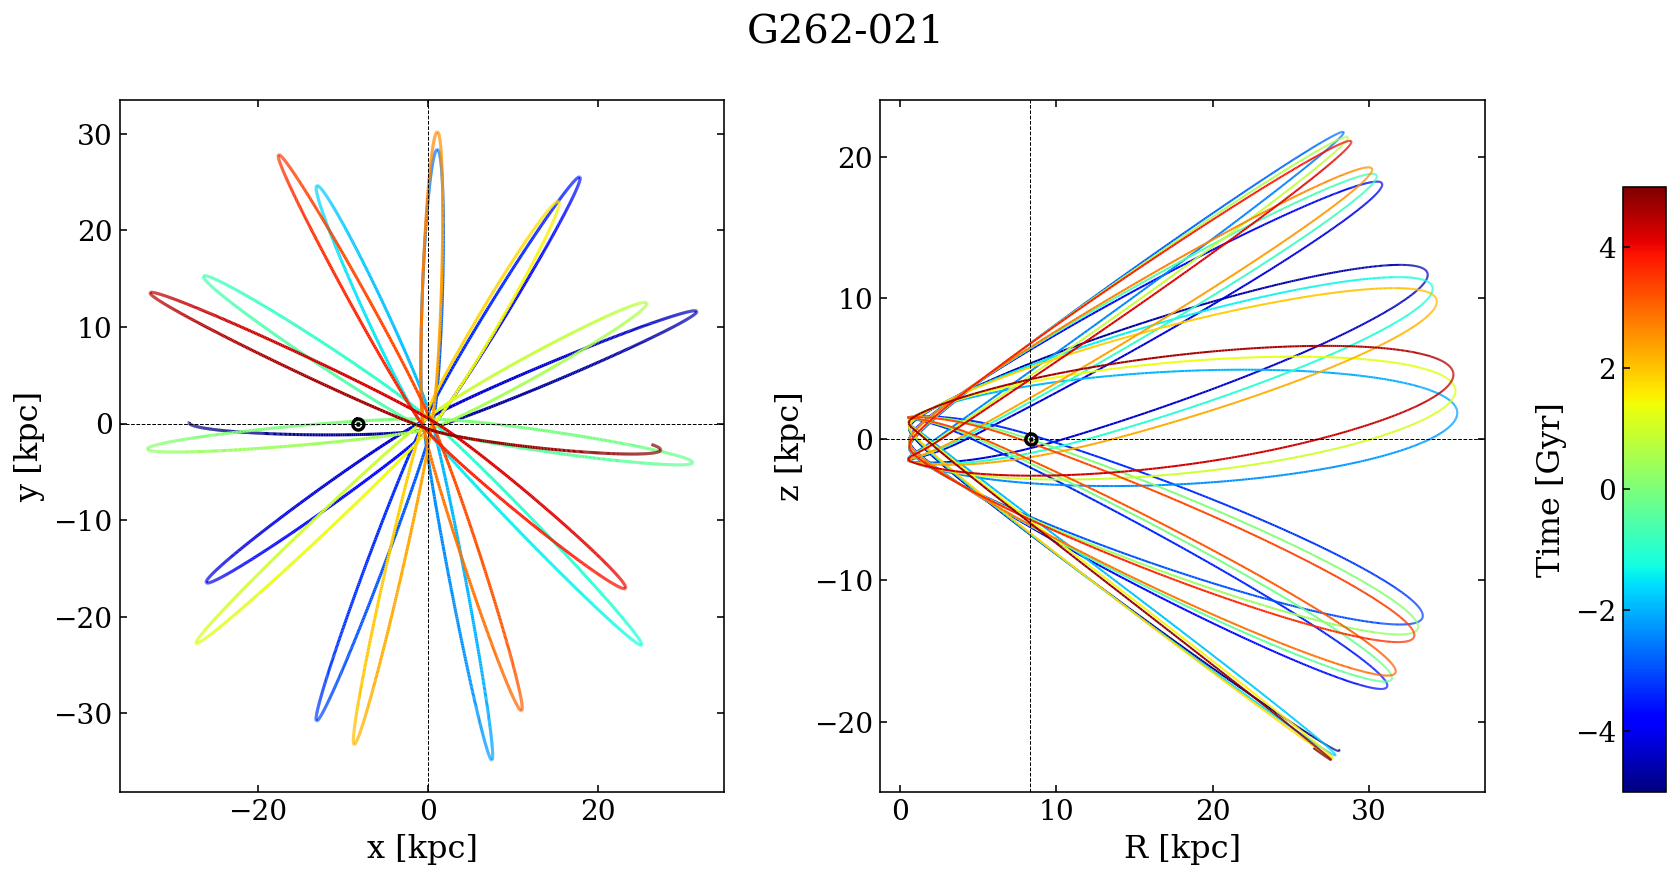

In [24]:
for i in range(n_stars):
    
    # Get the data
    ra = tab[i]['ra']
    dec = tab[i]['dec']
    pmra = tab[i]['pmra']
    pmdec = tab[i]['pmdec']
    dist = 1/tab[i]['parallax']
    rv = vrad[i]
    
    # Set timing
    n_snaps = 1000 * t_orbit # 1/Myr
    times = np.linspace(0,t_orbit,n_snaps) * apu.Gyr
    
    # Instantiate the orbits
    o_ft = orbit.Orbit( vxvv=[ra, dec, dist, pmra, pmdec, rv], radec=True )
    o_rt = orbit.Orbit( vxvv=[ra, dec, dist, pmra, pmdec, rv], radec=True )
    o_rt.flip(inplace=True)
    
    # Integrate the orbit
    o_ft.integrate(times, pot)
    o_rt.integrate(times, pot)
    
    # Make lines between -t and t
    times_tot = np.append( -times[::-1], times )
    norm = plt.Normalize(-t_orbit, t_orbit)
    
    # Make the R-Z line
    R = np.append( o_rt.R(times)[::-1], o_ft.R(times) )
    z = np.append( o_rt.z(times)[::-1], o_ft.z(times) )
    Rz_pts = np.array([R, z]).T.reshape(-1, 1, 2)
    Rz_segs = np.concatenate([Rz_pts[:-1], Rz_pts[1:]], axis=1)
    Rz_lc = LineCollection(Rz_segs, cmap='jet', norm=norm)
    Rz_lc.set_array(times_tot)
    Rz_lc.set_linewidth(1)
    
    # Make the X-Y line between [-t,t]
    x = np.append( -o_rt.x(times)[::-1], -o_ft.x(times) )
    y = np.append( o_rt.y(times)[::-1], o_ft.y(times) )
    xy_pts = np.array([x, y]).T.reshape(-1, 1, 2)
    xy_segs = np.concatenate([xy_pts[:-1], xy_pts[1:]], axis=1)
    xy_lc = LineCollection(xy_segs, cmap='jet', norm=norm)
    xy_lc.set_array(times_tot)
    Rz_lc.set_linewidth(1)
    
    # Make the plot
    fig = plt.figure( figsize=(12,6) )
    ax1 = fig.add_axes([0.08, 0.15, 0.35, 0.8])
    ax2 = fig.add_axes([0.52, 0.15, 0.35, 0.8])
    
    # Add the lines
    xy_line = ax1.add_collection(xy_lc)
    Rz_line = ax2.add_collection(Rz_lc)
    
    # Decorate
    ax1.scatter(-8.3, 0,marker=r'$\odot$', color='Black', label='Sun', s=50, zorder=10)
    ax1.axvline(0, linestyle='dashed', color='Black', linewidth=0.5)
    ax1.axhline(0, linestyle='dashed', color='Black', linewidth=0.5)
    ax1.set_xlabel(r'x [kpc]', fontsize=16)
    ax1.set_ylabel(r'y [kpc]', fontsize=16)
    ax1.tick_params(direction='in', right='on', top='on', labelsize=14)
    
    ax2.scatter(8.3, 0.025, marker=r'$\odot$', color='Black', label='Sun', s=50, zorder=10)
    ax2.axvline(8.3, linestyle='dashed', color='Black', linewidth=0.5)
    ax2.axhline(0, linestyle='dashed', color='Black', linewidth=0.5)
    ax2.set_xlabel(r'R [kpc]', fontsize=16)
    ax2.set_ylabel(r'z [kpc]', fontsize=16)
    ax2.tick_params(direction='in', right='on', top='on', labelsize=14)
    
    # Colorbar
    cax = fig.add_axes([0.95,0.15,0.025,0.7])
    ax2_cbar = fig.colorbar(Rz_line, cax=cax, orientation='vertical')
    ax2_cbar.set_label( 'Time [Gyr]', fontsize=16)
    cax.yaxis.set_label_position('left')
    cax.tick_params(axis='both', which='both', direction='in', right='off', left='on',
                    labelsize=14, labelleft='on', labelright='off')

    fig.suptitle(star_names[i], fontsize=20, y=1.05)
    plt.show()
    plt.close('all')
    
###i